In [1]:
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

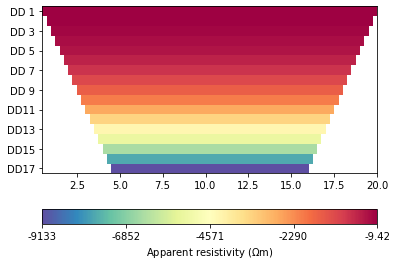

In [2]:
# create measuring scheme (data container without data)
scheme = ert.createData(elecs=42, spacing=0.5, schemeName='dd')
scheme["k"] = ert.geometricFactors(scheme)
scheme.remove(pg.abs(scheme["k"]) > 10000)
ert.show(scheme, "k");

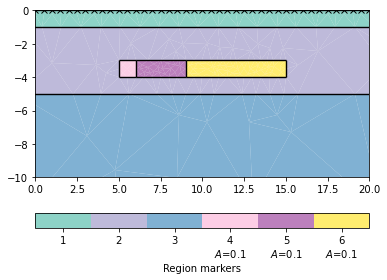

In [3]:
world = mt.createWorld(start=[-50, 0], end=[100, -50],
                       layers=[-1, -5], worldMarker=True)
for pos in scheme.sensorPositions():
    world.createNode(pos, marker=-99)
    world.createNode(pos+pg.RVector3(0, -0.2))

# Create some heterogeneous block
plcs = [world]
pos = [5, 6, 9, 15]
nT = len(pos) - 1  # number of time steps
for i in range(nT):
    block = mt.createRectangle(start=[pos[i], -3], end=[pos[i+1], -4],
                               area=0.1, marker=4+i)
    plcs.append(block)

geom = mt.mergePLC(plcs)
ax, _ = pg.show(geom)
ax.set_xlim(0, 20)
ax.set_ylim(-10, 0)
ax.plot(pg.x(scheme), pg.y(scheme), 'kx')

Mesh: Nodes: 2149 Cells: 4040 Boundaries: 6188


(-10.0, 0.0)

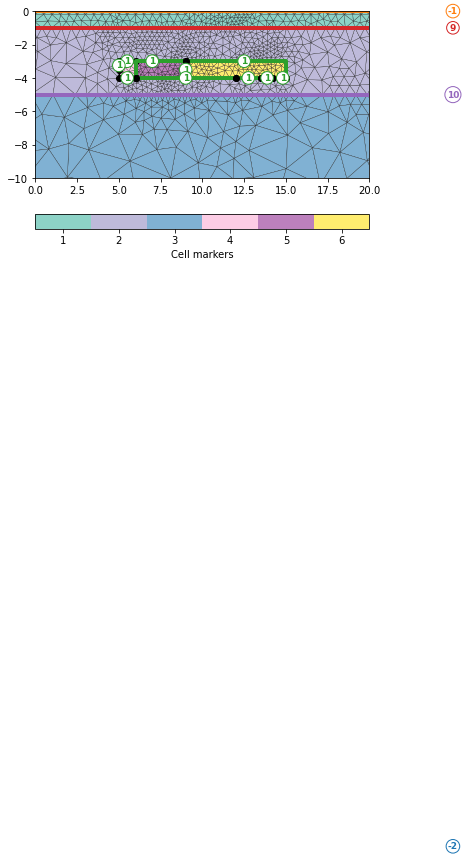

In [4]:
mesh = mt.createMesh(geom, quality=34.4)
print(mesh)
ax, _ = pg.show(mesh, markers=True, showMesh=True)
ax.set_xlim(0, 20)
ax.set_ylim(-10, 0)

[[1, 100.0], [2, 50.0], [3, 20.0], [4, 50.0], [5, 50.0], [6, 50.0]]


(-10.0, 0.0)

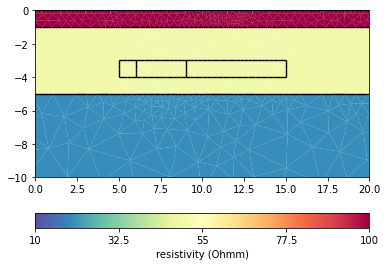

In [7]:
rhomap = [[1, 100.], [2, 50.], [3, 20.]]
for i in range(nT):
    rhomap.append([i+4, rhomap[1][1]])  # anomalies with 2nd layer

print(rhomap)
ax, cb = pg.show(mesh, rhomap, label="resistivity (Ohmm)", cMap="Spectral_r", cMin=10, cMax=100)
ax.set_xlim(0, 20)
ax.set_ylim(-10, 0)

Data error estimate (min:max)  0.01 : 0.01
Data error estimate (min:max)  0.01 : 0.01
Data error estimate (min:max)  0.01 : 0.01
Data error estimate (min:max)  0.01 : 0.01
Data error estimate (min:max)  0.01 : 0.01


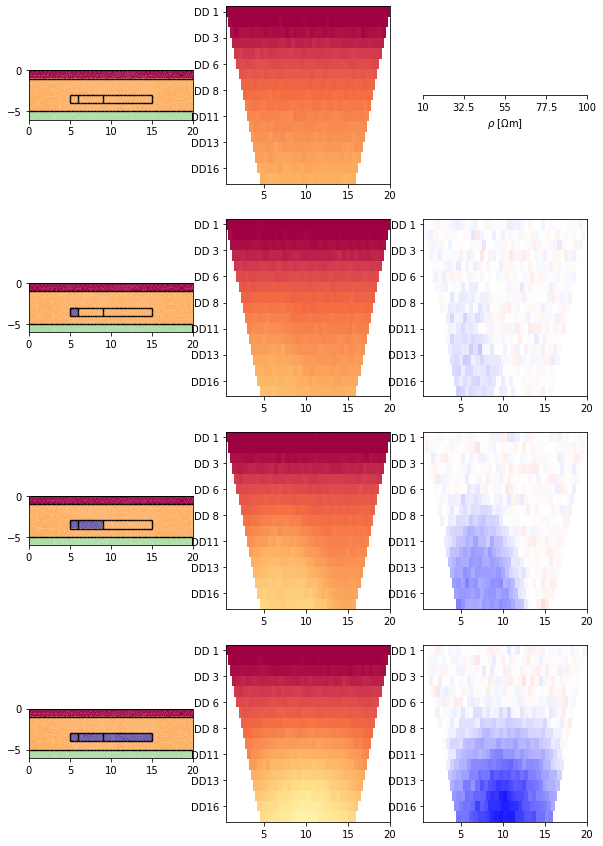

In [6]:
rhomap = [[1, 100.0], [2, 50.0], [3, 20.0], [4, 50.0], [5, 50.0], [6, 50.0]]
noise = dict(noiseLevel=0.01, noiseAbs=0)
mgr = ert.Manager()
data = ert.simulate(mesh=mesh, res=rhomap, scheme=scheme, **noise)
rhoTracer = 10
cDict = dict(colorBar=False, cMin=10, cMax=100, logScale=1, cMap='Spectral_r')
fig, ax = pg.plt.subplots(figsize=(10, 15), nrows=nT+1, ncols=3)
DATA = []
for i in range(nT+1):
    pg.show(mesh, rhomap, ax=ax[i, 0], **cDict)
    ax[i, 0].set_xlim(0, 20)
    ax[i, 0].set_ylim(-6, 0)
    data = ert.simulate(mesh, res=rhomap, scheme=scheme, **noise)
    data.save('data{:d}.dat'.format(i))
    DATA.append(data)
    ert.show(data, ax=ax[i, 1], **cDict)
    ratio = data('rhoa') / DATA[0]('rhoa')
    if i > 0:
        ert.show(data, ratio, ax=ax[i, 2],
                cMap='bwr', cMin=1/1.5, cMax=1.5, colorBar=False)
    if i < nT:
        rhomap[3+i][1] = rhoTracer

cDict.pop('colorBar')
cDict['label'] = r'$\rho$ [$\Omega$m]'
pg.viewer.mpl.colorbar.createColorBarOnly(ax=ax[0, 2], **cDict)
ax[0, 2].set_aspect(0.1)